Estudo baseado nos seguintes artigos:

* [Dealing with unbalanced data in machine learning](https://www.r-bloggers.com/dealing-with-unbalanced-data-in-machine-learning/)

* [Building meaningful machine learning models for disease prediction](https://shiring.github.io/machine_learning/2017/03/31/webinar_code)

O dataset usado pode ser baixado [aqui](http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data)

In [5]:
library(caret) # short for _C_lassification _A_nd _RE_gression _T_raining
# http://topepo.github.io/caret/index.html

library(ggplot2)

Preparando df.

In [2]:
bc_data <- read.table("data/breast-cancer-wisconsin.data.txt", 
                      header = FALSE, 
                      sep = ",")
colnames(bc_data) <- c("sample_code_number", 
                       "clump_thickness", 
                       "uniformity_of_cell_size", 
                       "uniformity_of_cell_shape", 
                       "marginal_adhesion", 
                       "single_epithelial_cell_size", 
                       "bare_nuclei", 
                       "bland_chromatin", 
                       "normal_nucleoli", 
                       "mitosis", 
                       "classes")

bc_data$classes <- ifelse(bc_data$classes == "2", "benign",
                          ifelse(bc_data$classes == "4", "malignant", NA))

In [3]:
head(bc_data)

sample_code_number,clump_thickness,uniformity_of_cell_size,uniformity_of_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitosis,classes
1000025,5,1,1,1,2,1,3,1,1,benign
1002945,5,4,4,5,7,10,3,2,1,benign
1015425,3,1,1,1,2,2,3,1,1,benign
1016277,6,8,8,1,3,4,3,7,1,benign
1017023,4,1,1,3,2,1,3,1,1,benign
1017122,8,10,10,8,7,10,9,7,1,malignant


Temos duas vezes mais câncer do tipo *benign* do que o câncer *malignat* em nosso dataset.

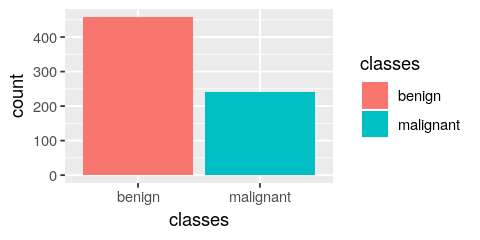

In [9]:
options(repr.plot.width=4, repr.plot.height=2)

ggplot(bc_data, aes(x = classes, fill = classes)) +
  geom_bar()

# Modelando com o Dataset Desbalanceado

In [20]:
library(randomForest)
library(e1071)

In [10]:
set.seed(42)
index <- createDataPartition(bc_data$classes, p = 0.7, list = FALSE)
train_data <- bc_data[index, ]
test_data  <- bc_data[-index, ]

Vamos usar treinar um modelo do tipo Random Forest.

In [19]:
model_rf <- caret::train(classes ~ .,
                         data = train_data,
                         method = "rf",
                         preProcess = c("scale", "center"),
                         trControl = trainControl(method = "repeatedcv", 
                                                  number = 10, 
                                                  repeats = 10, 
                                                  verboseIter = FALSE))

Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
“These variables have zero variances: bare_nuclei6”Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
“These variables have zero variances: bare_nuclei6”Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
“These variables have zero variances: bare_nuclei6”Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
“These variables have zero variances: bare_nuclei6”Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
“These variables have zero variances: bare_nuclei6”Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
“These variables have zero variances: bare_nuclei6”

In [26]:
final <- data.frame(actual = test_data$classes,
                    predict(model_rf, newdata = test_data, type = "prob"))

final$predict <- as.factor(ifelse(final$benign > 0.5, "benign", "malignant"))

In [30]:
cm_original <- confusionMatrix(final$predict, as.factor(test_data$classes))
cm_original

Confusion Matrix and Statistics

           Reference
Prediction  benign malignant
  benign       133         0
  malignant      4        72
                                          
               Accuracy : 0.9809          
                 95% CI : (0.9517, 0.9948)
    No Information Rate : 0.6555          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9582          
 Mcnemar's Test P-Value : 0.1336          
                                          
            Sensitivity : 0.9708          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.9474          
             Prevalence : 0.6555          
         Detection Rate : 0.6364          
   Detection Prevalence : 0.6364          
      Balanced Accuracy : 0.9854          
                                          
       'Positive' Class : benign          
                                          

# Modelando Usando a Tecnica de  under-sampling

In [31]:
ctrl <- trainControl(method = "repeatedcv", 
                     number = 10, 
                     repeats = 10, 
                     verboseIter = FALSE,
                     sampling = "down")

In [32]:
model_rf_under <- caret::train(classes ~ .,
                         data = train_data,
                         method = "rf",
                         preProcess = c("scale", "center"),
                         trControl = ctrl)

In [33]:
final_under <- data.frame(actual = test_data$classes,
                    predict(model_rf_under, newdata = test_data, type = "prob"))

final_under$predict <- as.factor(ifelse(final_under$benign > 0.5, "benign", "malignant"))

In [35]:
cm_under <- confusionMatrix(final_under$predict, as.factor(test_data$classes))
cm_under

Confusion Matrix and Statistics

           Reference
Prediction  benign malignant
  benign       132         0
  malignant      5        72
                                          
               Accuracy : 0.9761          
                 95% CI : (0.9451, 0.9922)
    No Information Rate : 0.6555          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.9479          
 Mcnemar's Test P-Value : 0.07364         
                                          
            Sensitivity : 0.9635          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.9351          
             Prevalence : 0.6555          
         Detection Rate : 0.6316          
   Detection Prevalence : 0.6316          
      Balanced Accuracy : 0.9818          
                                          
       'Positive' Class : benign          
                                          

# Modelando Usando a Tecnica de  over-sampling

In [36]:
ctrl <- trainControl(method = "repeatedcv", 
                     number = 10, 
                     repeats = 10, 
                     verboseIter = FALSE,
                     sampling = "up")

In [37]:
model_rf_over <- caret::train(classes ~ .,
                         data = train_data,
                         method = "rf",
                         preProcess = c("scale", "center"),
                         trControl = ctrl)

Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
“These variables have zero variances: bare_nuclei6”Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
“These variables have zero variances: bare_nuclei6”Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
“These variables have zero variances: bare_nuclei6”

In [38]:
final_over <- data.frame(actual = test_data$classes,
                          predict(model_rf_over, newdata = test_data, type = "prob"))

final_over$predict <- as.factor(ifelse(final_over$benign > 0.5, "benign", "malignant"))

In [39]:
cm_over <- confusionMatrix(final_over$predict, as.factor(test_data$classes))
cm_over

Confusion Matrix and Statistics

           Reference
Prediction  benign malignant
  benign       133         0
  malignant      4        72
                                          
               Accuracy : 0.9809          
                 95% CI : (0.9517, 0.9948)
    No Information Rate : 0.6555          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9582          
 Mcnemar's Test P-Value : 0.1336          
                                          
            Sensitivity : 0.9708          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.9474          
             Prevalence : 0.6555          
         Detection Rate : 0.6364          
   Detection Prevalence : 0.6364          
      Balanced Accuracy : 0.9854          
                                          
       'Positive' Class : benign          
                                          

# Desbalanceando usando a Técnica "Rose"


From Nicola Lunardon, Giovanna Menardi and Nicola Torelli’s “ROSE: A Package for Binary Imbalanced Learning” (R Journal, 2014, Vol. 6 Issue 1, p. 79): “The ROSE package provides functions to deal with binary classification problems in the presence of imbalanced classes. Artificial balanced samples are generated according to a smoothed bootstrap approach and allow for aiding both the phases of estimation and accuracy evaluation of a binary classifier in the presence of a rare class. Functions that implement more traditional remedies for the class imbalance and different metrics to evaluate accuracy are also provided. These are estimated by holdout, bootstrap, or cross-validation methods.”

In [45]:
library(ROSE)

In [46]:
ctrl <- trainControl(method = "repeatedcv", 
                     number = 10, 
                     repeats = 10, 
                     verboseIter = FALSE,
                     sampling = "rose")

In [47]:
model_rf_rose <- caret::train(classes ~ .,
                              data = train_data,
                              method = "rf",
                              preProcess = c("scale", "center"),
                              trControl = ctrl)

Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
“These variables have zero variances: bare_nuclei6”Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
“These variables have zero variances: bare_nuclei6”Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
“These variables have zero variances: bare_nuclei6”

In [48]:
final_rose <- data.frame(actual = test_data$classes,
                         predict(model_rf_rose, newdata = test_data, type = "prob"))

final_rose$predict <- as.factor(ifelse(final_rose$benign > 0.5, "benign", "malignant"))

In [49]:
test_data$classes = as.factor(test_data$classes)

In [51]:
cm_rose <- confusionMatrix(final_rose$predict, test_data$classes)
cm_rose

Confusion Matrix and Statistics

           Reference
Prediction  benign malignant
  benign       133         4
  malignant      4        68
                                         
               Accuracy : 0.9617         
                 95% CI : (0.926, 0.9833)
    No Information Rate : 0.6555         
    P-Value [Acc > NIR] : <2e-16         
                                         
                  Kappa : 0.9152         
 Mcnemar's Test P-Value : 1              
                                         
            Sensitivity : 0.9708         
            Specificity : 0.9444         
         Pos Pred Value : 0.9708         
         Neg Pred Value : 0.9444         
             Prevalence : 0.6555         
         Detection Rate : 0.6364         
   Detection Prevalence : 0.6555         
      Balanced Accuracy : 0.9576         
                                         
       'Positive' Class : benign         
                                         

# Desbalanceando usando a Técnica "SMOTE"

From Nitesh V. Chawla, Kevin W. Bowyer, Lawrence O. Hall and W. Philip Kegelmeyer’s “SMOTE: Synthetic Minority Over-sampling Technique” (Journal of Artificial Intelligence Research, 2002, Vol. 16, pp. 321–357): “This paper shows that a combination of our method of over-sampling the minority (abnormal) class and under-sampling the majority (normal) class can achieve better classifier performance (in ROC space) than only under-sampling the majority class. This paper also shows that a combination of our method of over-sampling the minority class and under-sampling the majority class can achieve better classifier performance (in ROC space) than varying the loss ratios in Ripper or class priors in Naive Bayes. Our method of over-sampling the minority class involves creating synthetic minority class examples.”

In [56]:
library(DMwR)

In [52]:
ctrl <- trainControl(method = "repeatedcv", 
                     number = 10, 
                     repeats = 10, 
                     verboseIter = FALSE,
                     sampling = "smote")

In [57]:
model_rf_smote <- caret::train(classes ~ .,
                              data = train_data,
                              method = "rf",
                              preProcess = c("scale", "center"),
                              trControl = ctrl)

Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
“These variables have zero variances: bare_nuclei6”Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
“These variables have zero variances: bare_nuclei6”Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
“These variables have zero variances: bare_nuclei6”

In [58]:
final_smote <- data.frame(actual = test_data$classes,
                         predict(model_rf_smote, newdata = test_data, type = "prob"))

final_smote$predict <- as.factor(ifelse(final_smote$benign > 0.5, "benign", "malignant"))

In [59]:
cm_smote <- confusionMatrix(final_smote$predict, test_data$classes)
cm_smote

Confusion Matrix and Statistics

           Reference
Prediction  benign malignant
  benign       133         0
  malignant      4        72
                                          
               Accuracy : 0.9809          
                 95% CI : (0.9517, 0.9948)
    No Information Rate : 0.6555          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9582          
 Mcnemar's Test P-Value : 0.1336          
                                          
            Sensitivity : 0.9708          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.9474          
             Prevalence : 0.6555          
         Detection Rate : 0.6364          
   Detection Prevalence : 0.6364          
      Balanced Accuracy : 0.9854          
                                          
       'Positive' Class : benign          
                                          

# Comparando as Previsões

In [60]:
models <- list(original = model_rf,
                       under = model_rf_under,
                       over = model_rf_over,
                       smote = model_rf_smote,
                       rose = model_rf_rose)

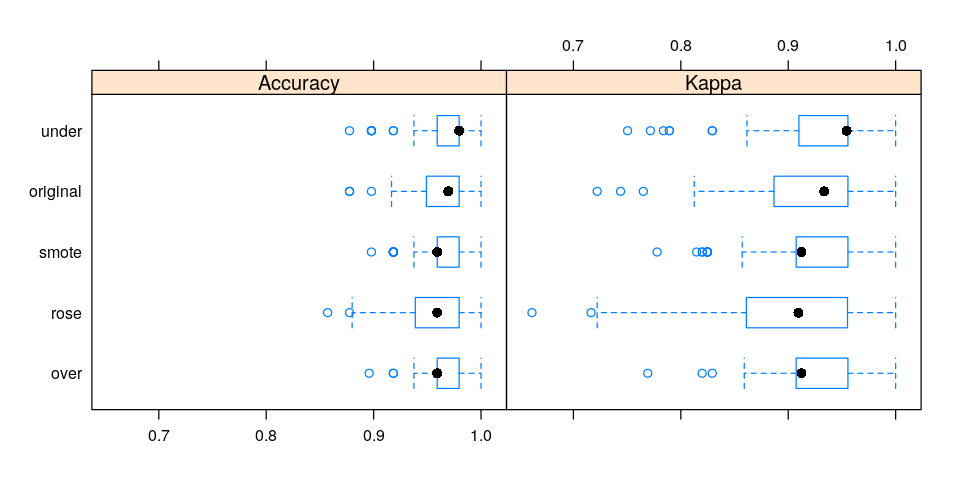

In [63]:
options(repr.plot.width=8, repr.plot.height=4)

resampling <- resamples(models)
bwplot(resampling)